# Performance Metrics

In this notebook we explore several performance metrics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, cross_val_predict, 
                                     GridSearchCV)
from sklearn.metrics import (confusion_matrix,precision_score,recall_score,auc,
                             f1_score, precision_recall_curve,accuracy_score)

C:\Users\frbj\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's look at a toy dataset

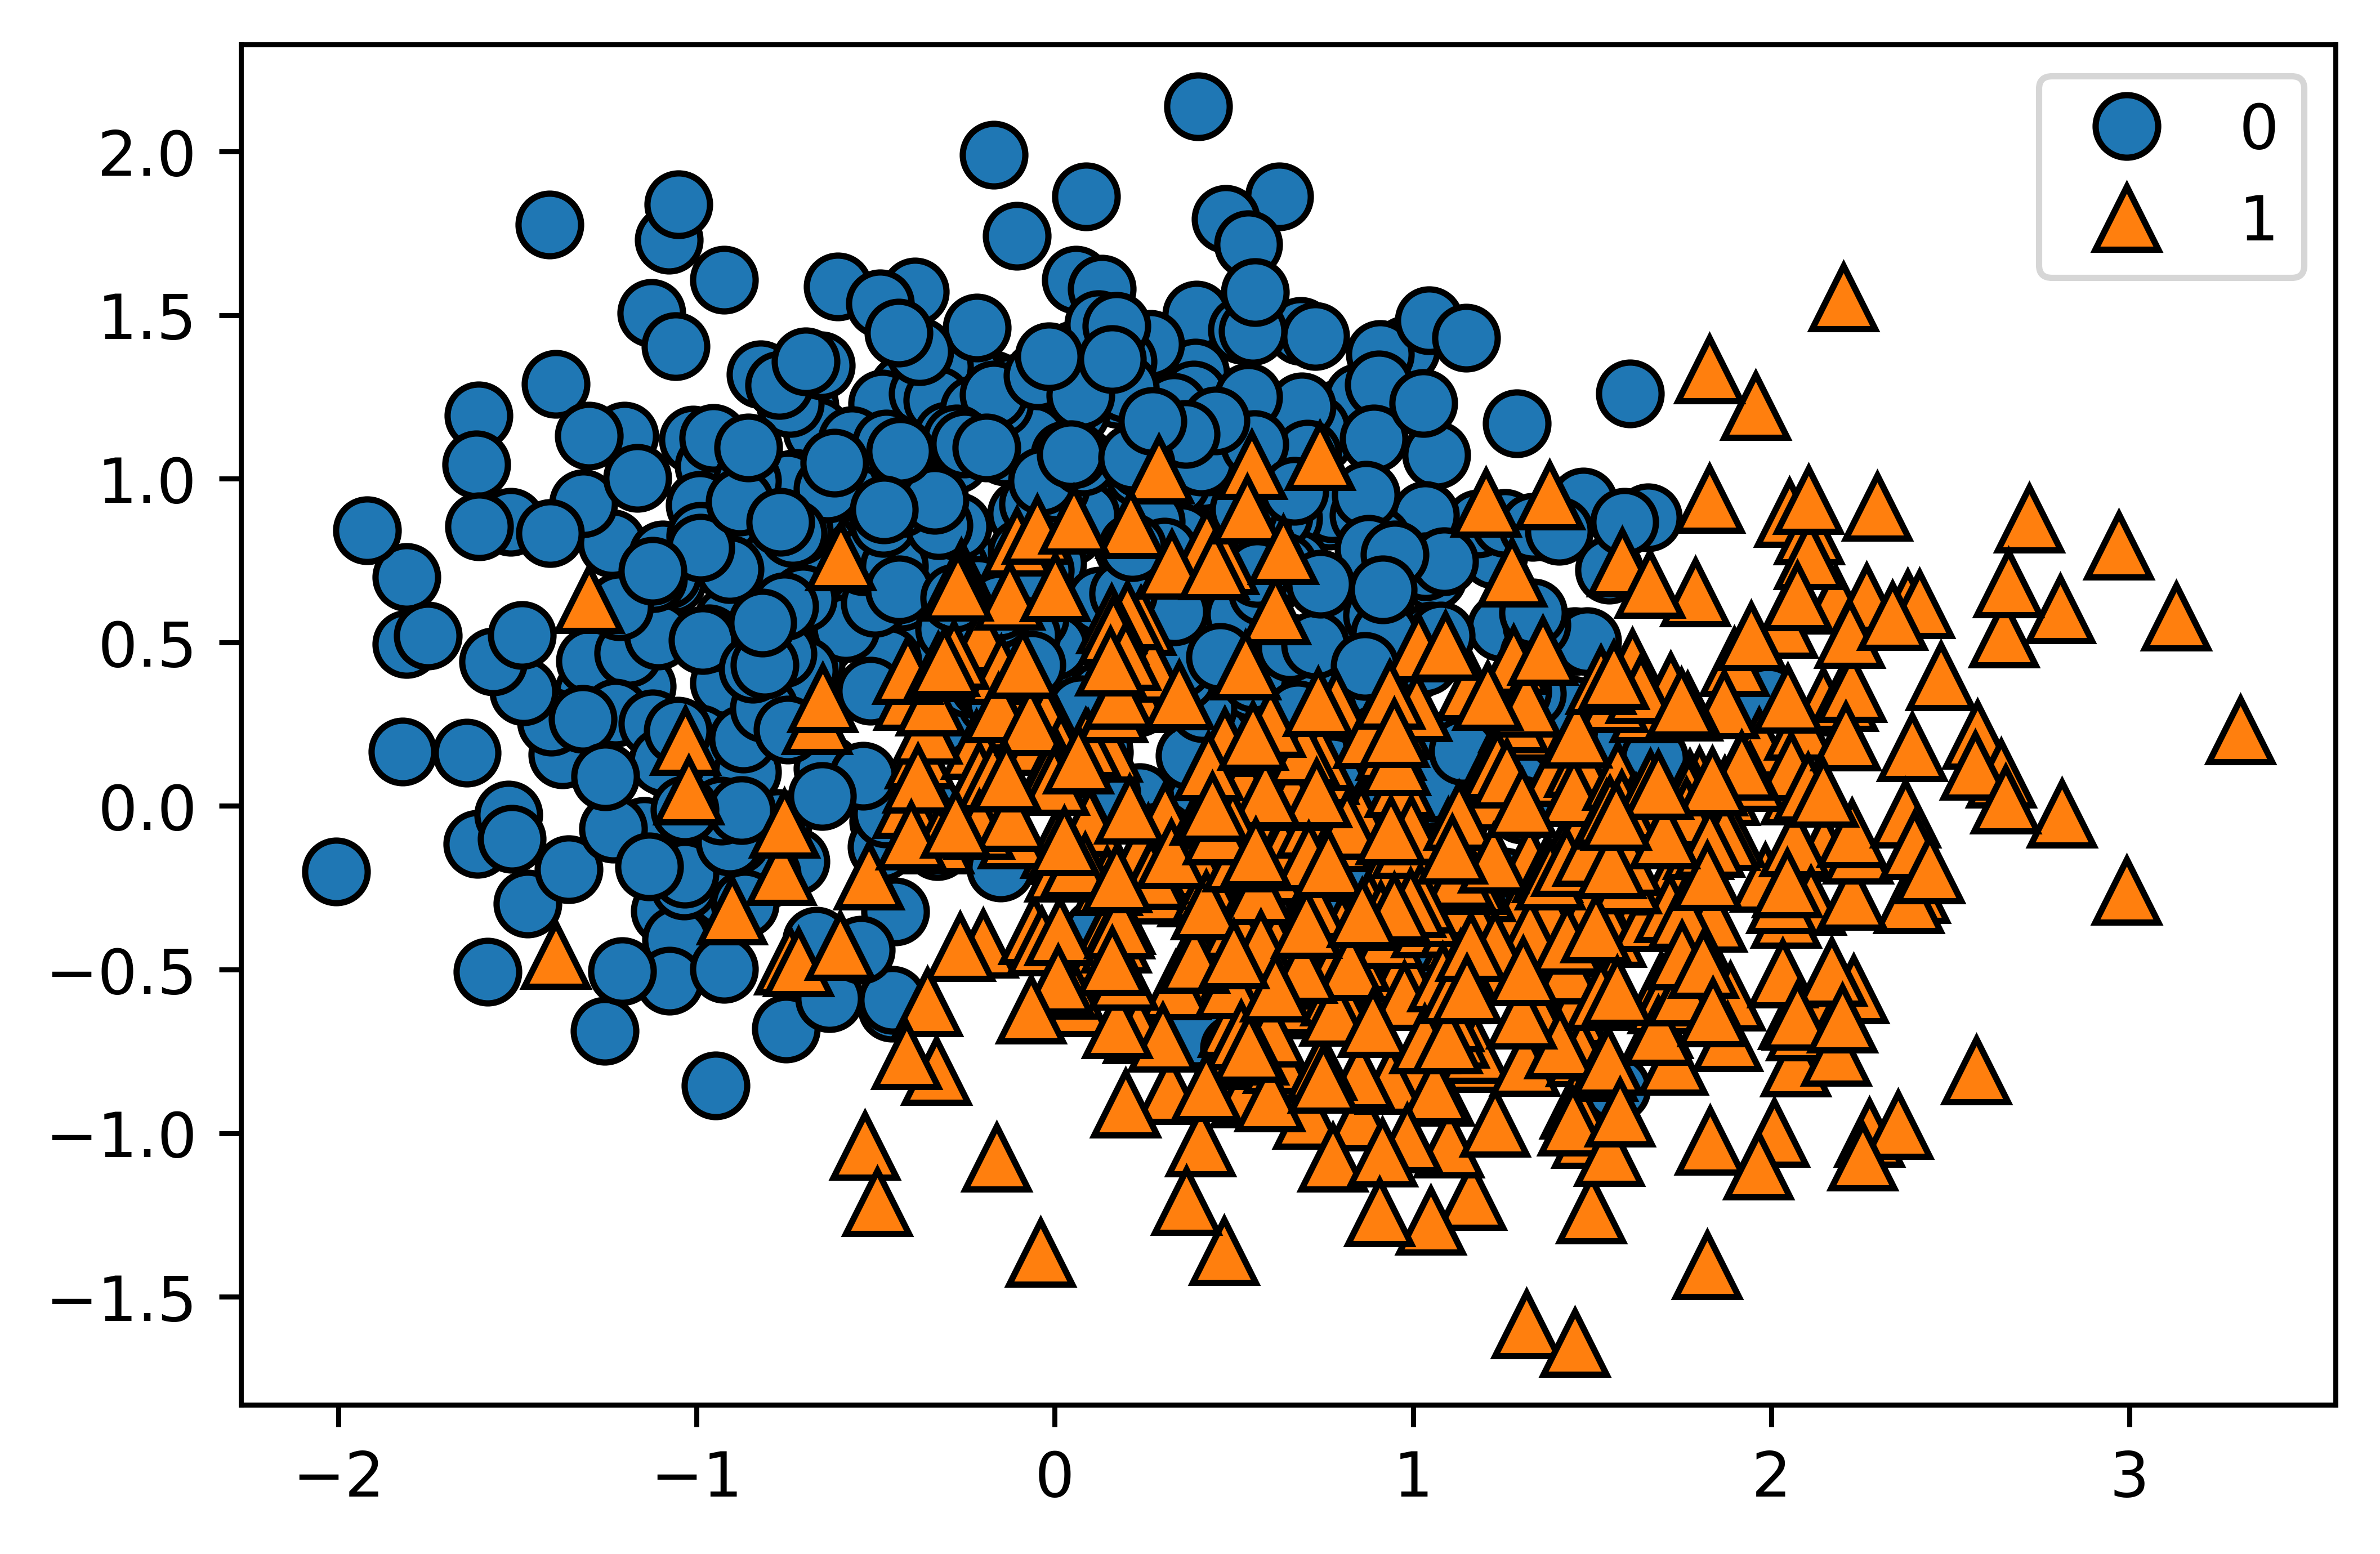

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 1000, noise = 0.45, random_state = 42)
plt.figure(dpi=800)
mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.legend()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    random_state = 42)

We look at the performance of an SVM:

In [4]:
clf = SVC(probability=True, C = 1, gamma = 1)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Confusion matrix:  \n{}\n".format(confusion_matrix(y_test,predictions)))
print("Accuracy: \n{}\n".format(clf.score(X_test,y_test)))
print("Precision: \n{}\n".format(precision_score(y_test,predictions)))
print("Recall: \n{}\n".format(recall_score(y_test,predictions)))
print("F1-score: \n{}".format(f1_score(y_test,predictions)))

Confusion matrix:  
[[109  16]
 [ 17 108]]

Accuracy: 
0.868

Precision: 
0.8709677419354839

Recall: 
0.864

F1-score: 
0.8674698795180723


**In the least, you need to be aware of the different metrics and investigate them all to see that, for example, you don't have a low recall you would have otherwise missed.**

From the sklearn documentation: 

"By definition a confusion matrix C is such that C(i,j) is equal to the number of observations known to be in group i and predicted to be in group j.

Thus in binary classification, the count of true negatives is C(0,0), false negatives is C(1,0), true positives is C(1,1) and false positives is C(0,1)."

So the structure of confusion matrix shown above is

    [[TN FP]

     [FN TP]]

## Precision-recall curve

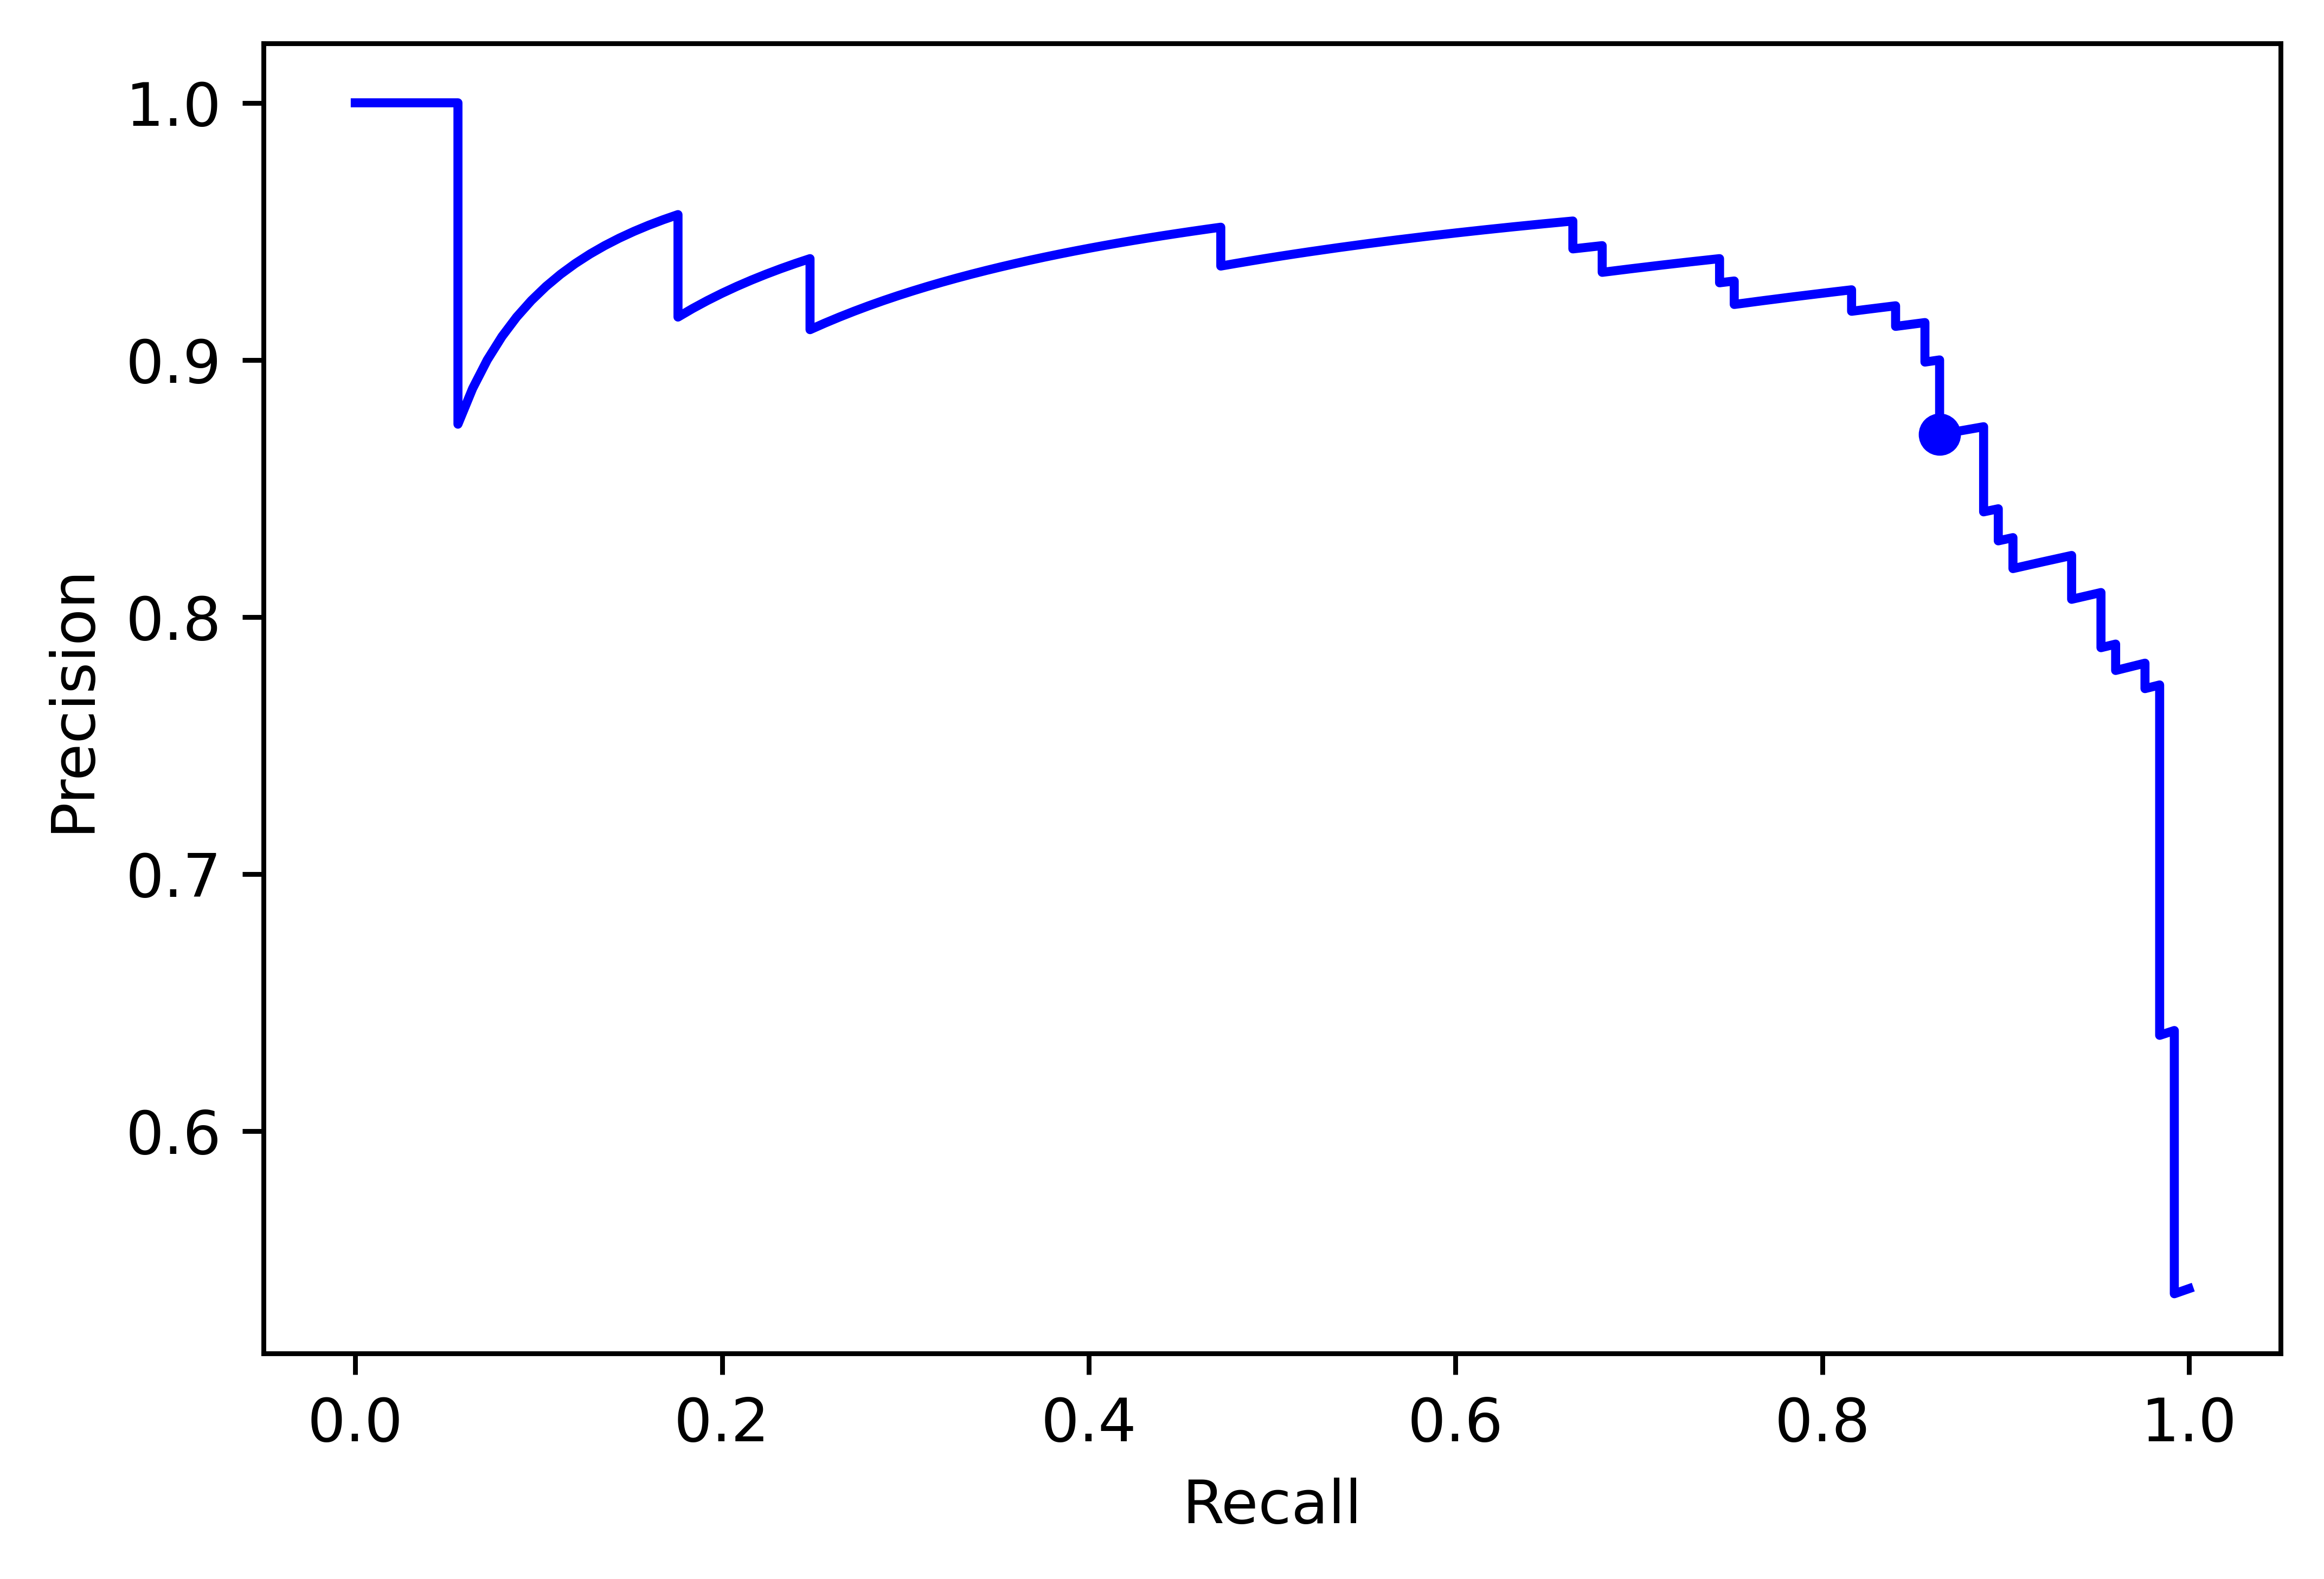

Area under curve is 0.919184.


In [5]:
prec,rec,thresholds = precision_recall_curve(y_test,
                                             clf.predict_proba(X_test)[:,1])
plt.figure(dpi=800)
plt.plot(rec,prec,'b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_score(y_test,predictions),
         precision_score(y_test,predictions),'bo')
plt.show()
print("Area under curve is {:f}.".format(auc(rec,prec)))

We could then plot this curve using a range of different models and see which one's got the highest AUC.

## Forcing the model to higher recall or precision

Let's look in detail at this threshold business. For SVM, the default threshold is 0.5 - when the models thinks there's more than a 50 % chance it's positive, it will be classified as positive. But we could force the model to change the threshold to avoid either false negatives or false positives. Now we're really going into the machine room and changing the fundamental assumptions of the algorithms - so you've got to be careful and know what you're doing! Let's say we're going for 95 % recall - at the expense of precision.

In [6]:
idx_for_95_recall = (rec > 0.95).argmin()
threshold_for_95_recall = thresholds[idx_for_95_recall]
threshold_for_95_recall

0.24176117628245372

So, rather than 50 %, we classify as positive as soon as we are more than 25 % certain it's a positive. If there's a 25 % chance we're dealing with a terrorist, we probably want to take an extra look at the person!

So what we have to do now is use the *probabilities* predicted by our SVM classifier and then build a new classifier with a threshold of 25 %:

In [7]:
predictions_95_rec = (clf.predict_proba(X_test)[:,1] >= threshold_for_95_recall)
print("Precision: {:.2f}".format(precision_score(y_test, predictions_95_rec)))
print("Recall: {:.2f}".format(recall_score(y_test, predictions_95_rec)))

Precision: 0.81
Recall: 0.94


Similarly, we could force our model to 95 % precision:

In [8]:
#note we use argmax here, not argmin - the recall and precision lists go in opposite orders
idx_for_95_precision = (prec > 0.95).argmax()
threshold_for_95_precision = thresholds[idx_for_95_precision]
threshold_for_95_precision
predictions_95_prec = (clf.predict_proba(X_test)[:,1] >= threshold_for_95_precision)
print("Precision: {:.2f}".format(precision_score(y_test, predictions_95_prec)))
print("Recall: {:.2f}".format(recall_score(y_test, predictions_95_prec)))

Precision: 0.95
Recall: 0.66


Let's replot the precision-recall curve to see where we've moved:

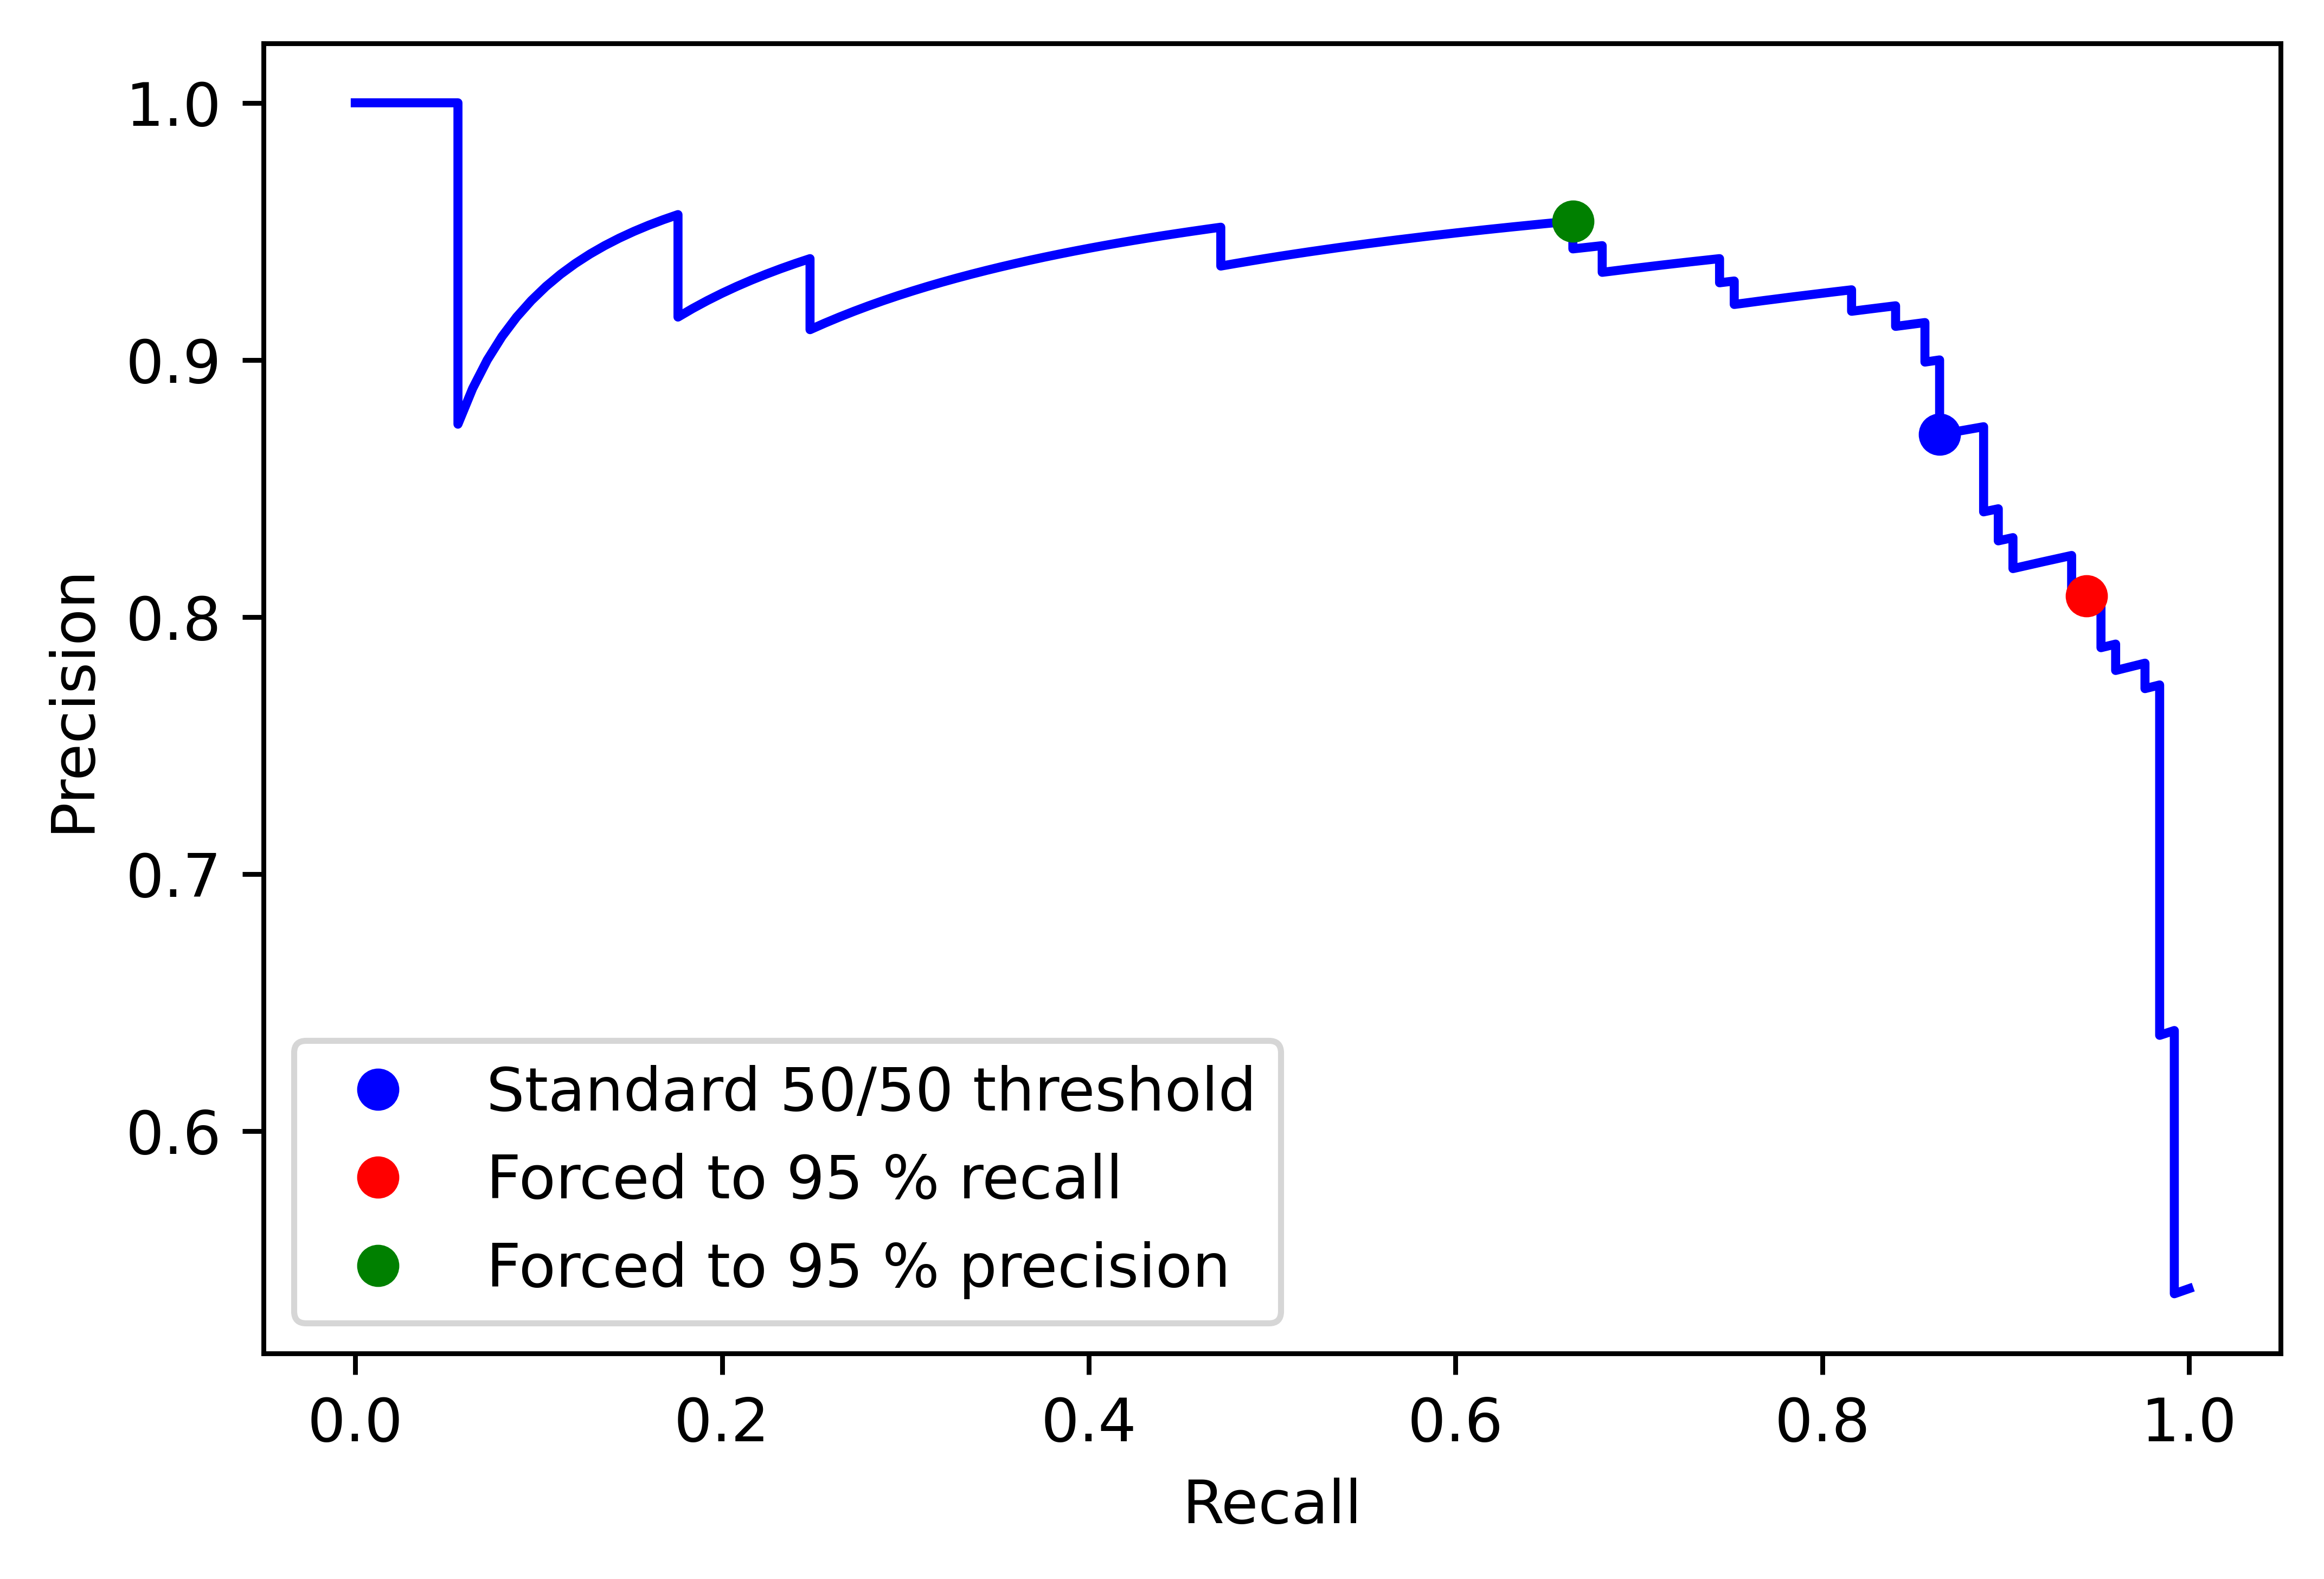

In [9]:
prec,rec,thresholds = precision_recall_curve(y_test,
                                             clf.predict_proba(X_test)[:,1])
plt.figure(dpi=800)
plt.plot(rec,prec,'b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_score(y_test,predictions),
         precision_score(y_test,predictions),'bo', label = "Standard 50/50 threshold")
plt.plot(recall_score(y_test, predictions_95_rec),
         precision_score(y_test, predictions_95_rec),'ro', label = "Forced to 95 % recall")
plt.plot(recall_score(y_test, predictions_95_prec),
         precision_score(y_test, predictions_95_prec),'go', label = "Forced to 95 % precision")
plt.legend()
plt.show()

Although it's rarely seen, we could explicitly plot the recall and precision against the threshold:

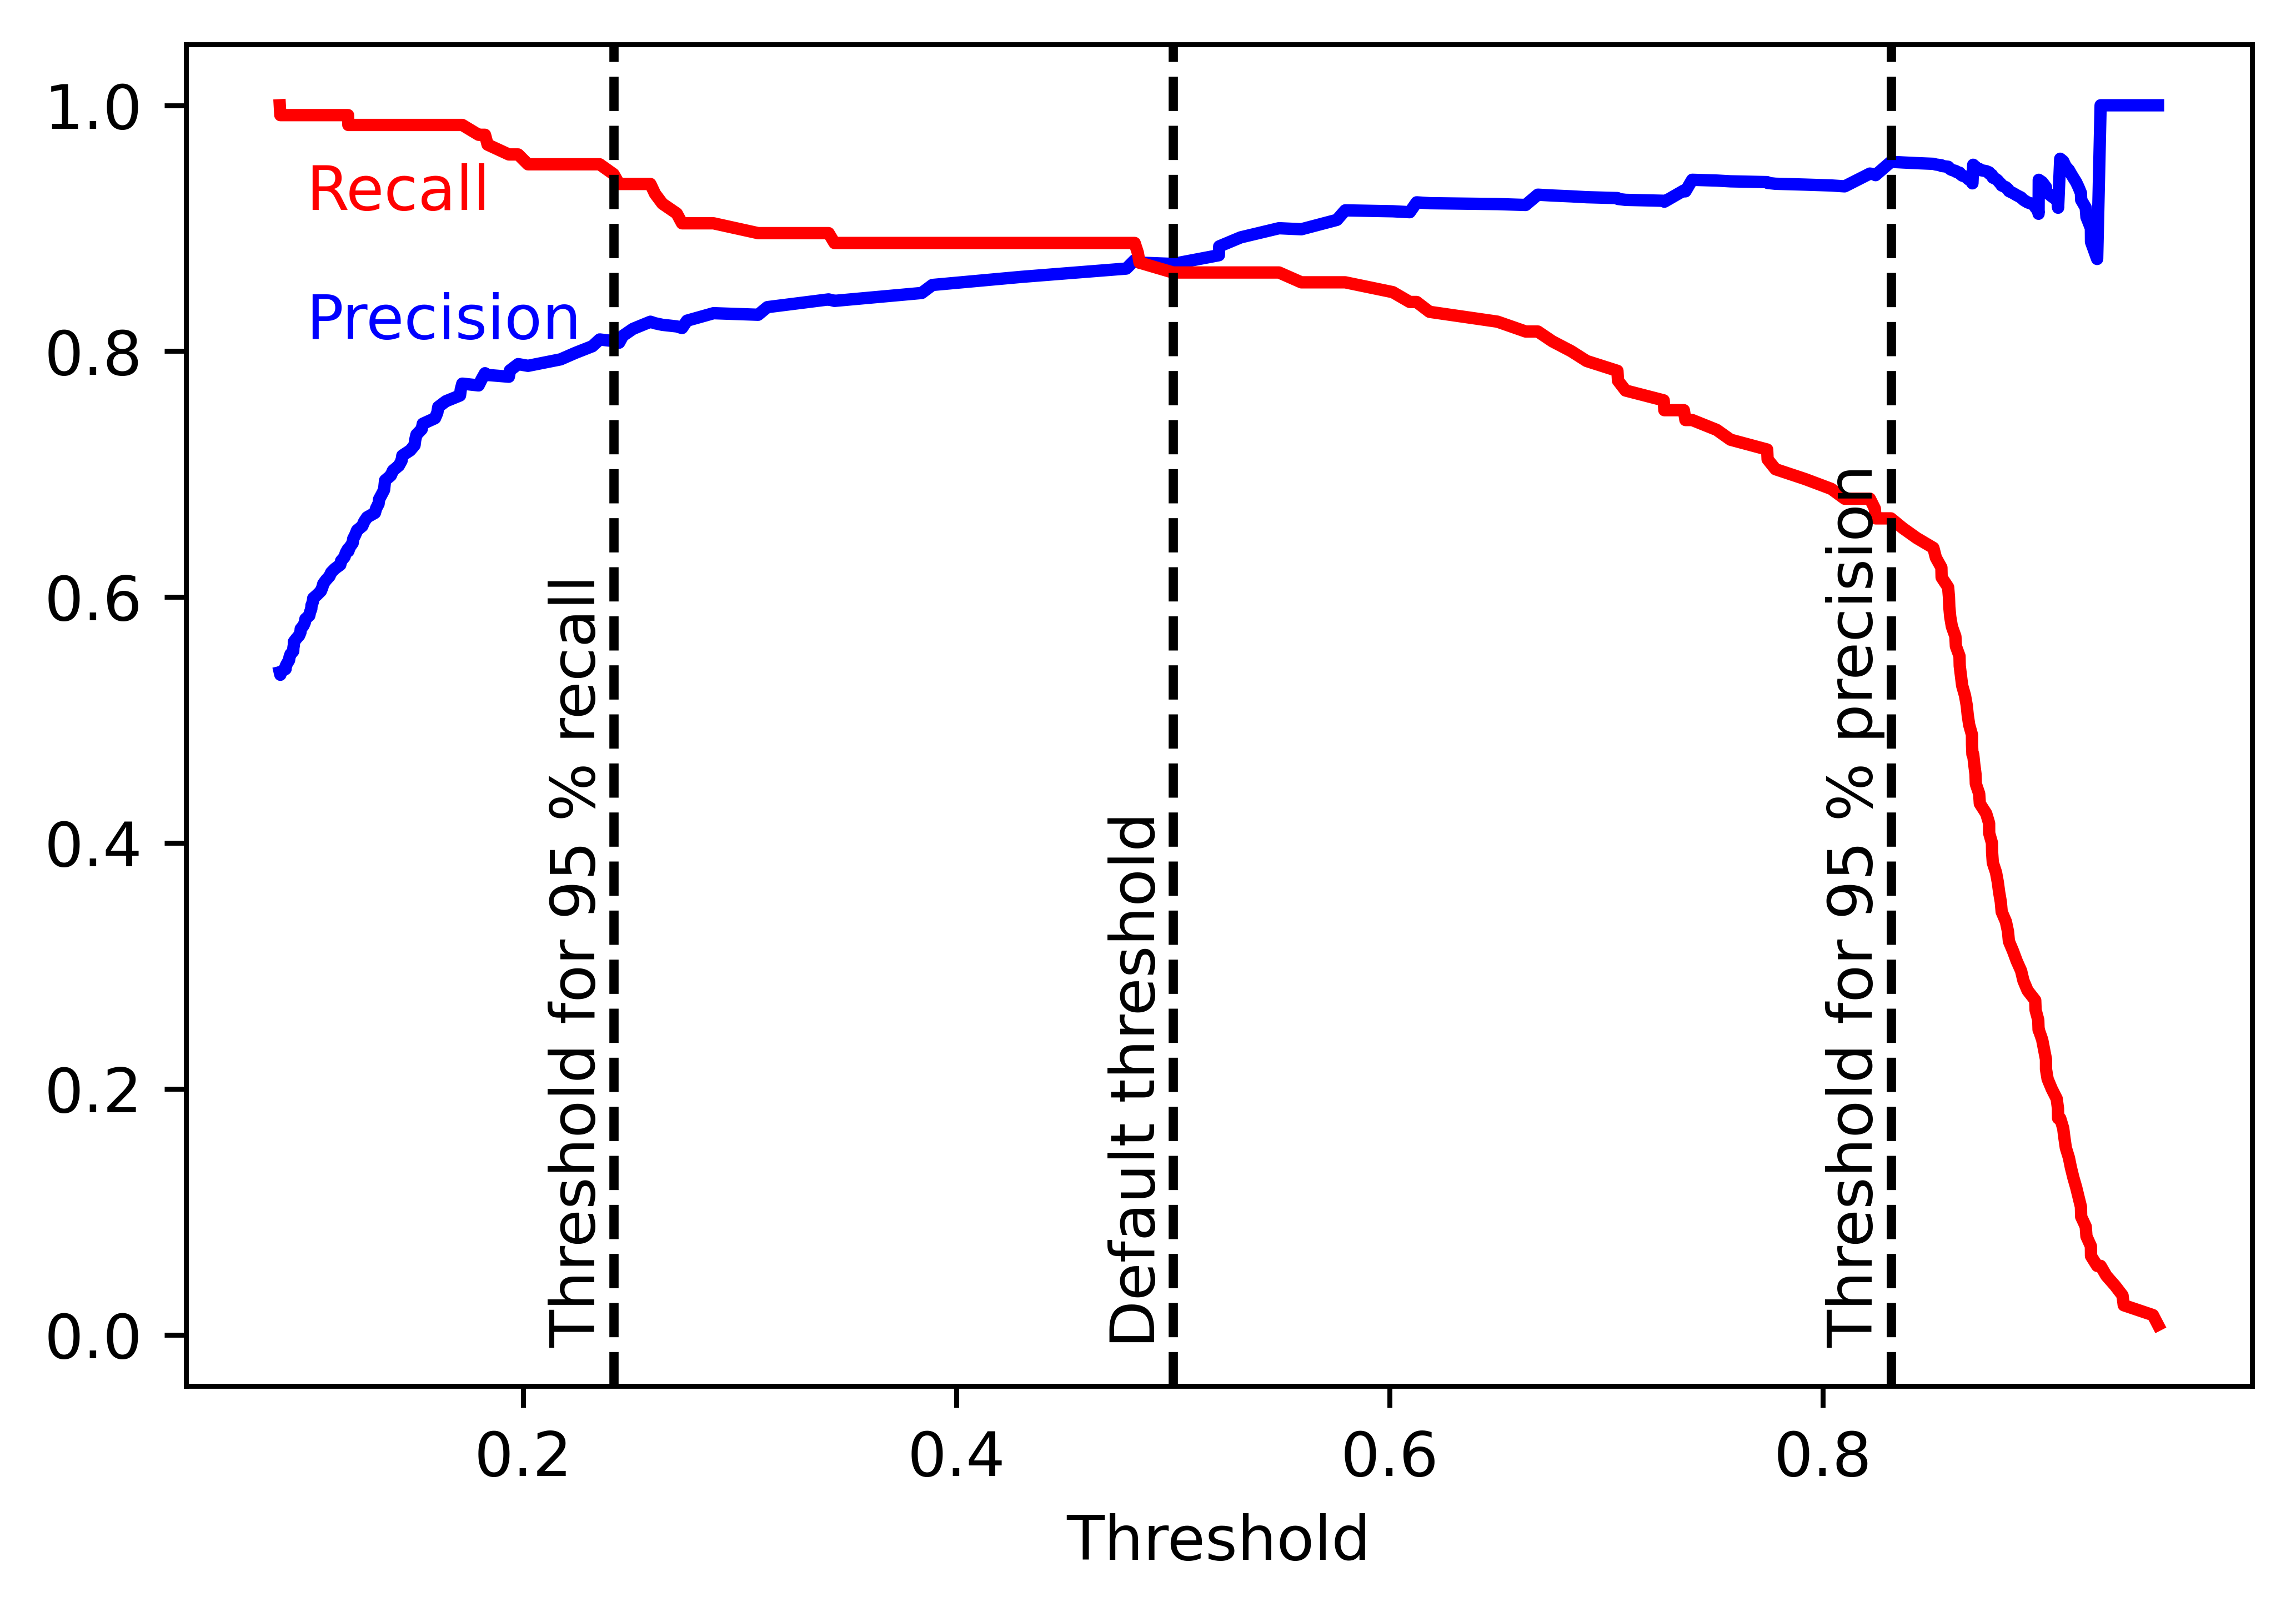

In [13]:
plt.figure(dpi = 800)
plt.plot(thresholds, prec[:-1], "b-", linewidth = 2)
plt.plot(thresholds, rec[:-1], "r-", linewidth = 2)

plt.axvline(threshold_for_95_precision, color = 'k', linestyle = '--')
plt.text(threshold_for_95_precision-0.03,0,'Threshold for 95 % precision',rotation=90)
plt.axvline(0.5, color = 'k', linestyle = '--')
plt.text(0.47,0,'Default threshold',rotation=90)
plt.axvline(threshold_for_95_recall, color = 'k', linestyle = '--')
plt.text(threshold_for_95_recall-0.03,0,'Threshold for 95 % recall',rotation=90)

plt.text(0.1,0.915,'Recall',color = 'r')
plt.text(0.1,0.81,'Precision',color = 'b')

plt.xlabel("Threshold")
plt.show()